In [13]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import pandas as pd
from sklearn.manifold import TSNE

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image


T = 30
lr = 0.1

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                            download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True)

testset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                           download=True, train=False, transform=transform)
validation_loader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True)
# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(testset)))


Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


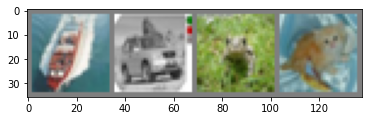

ship 


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))


In [3]:
def softmax_T(inputs, T):

    exp_values = (inputs / T).exp()
    probabilities = exp_values / torch.sum(exp_values, 1, True)
    return probabilities.log()


def my_cross_entropy(x, y, T):
    log_prob = -1.0 * softmax_T(x, T)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()


In [5]:
def train_one_epoch(epoch_index, tb_writer, T, lr):
    running_loss = 0.
    last_loss = 0.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = my_cross_entropy(outputs, labels, T)
        loss.backward()
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


In [6]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
EPOCHS = 4

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, T, lr)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = my_cross_entropy(voutputs, vlabels, T)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
  batch 1000 loss: 2.299880849480629
  batch 2000 loss: 2.297675673365593
  batch 3000 loss: 2.3001709426641463
  batch 4000 loss: 2.2748482862710953


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


embeddings = []
targets = []
with torch.no_grad():
    for i, data in enumerate(validation_loader):
        images, labels = data[0].to(device), data[1].to(device)
        embeddings.append(model(images).cpu().detach().numpy())
        targets.append(labels.cpu().detach().numpy())

flattened_emb = [val for sublist in embeddings for val in sublist]
flattened_target = [val for sublist in targets for val in sublist]


Accuracy of the network on the 10000 test images: 55 %


In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=21, n_iter=700)
tsne_proj = tsne.fit_transform(flattened_emb)

df = pd.DataFrame()
df['x'] = tsne_proj[:, 0]
df['y'] = tsne_proj[:, 1]
df['label'] = flattened_target


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.605s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 17.295832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.374275
[t-SNE] KL divergence after 700 iterations: 1.712505


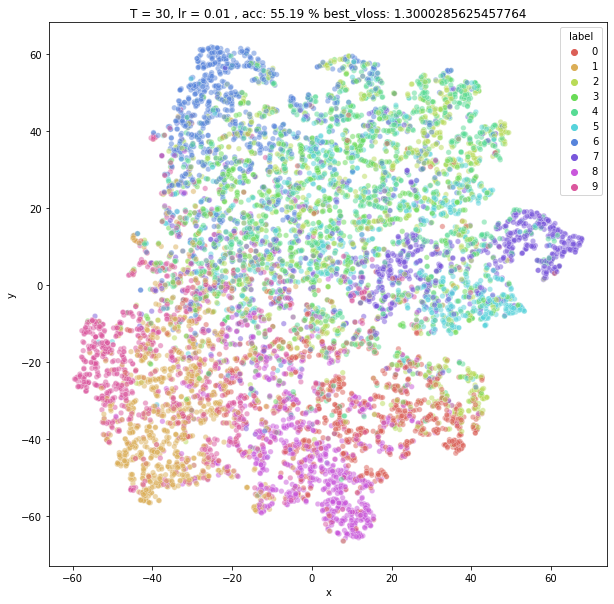

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
plot_path = f'plots/{timestamp}.png'

plt.figure(figsize=[10, 10])
sns.scatterplot(data=df, x="x", y="y", alpha=0.5, hue='label', palette=sns.color_palette(
    "hls", 10), s=30).set(title=f"T = {T}, lr = {lr} , acc: {100 * correct / total} % best_vloss: {best_vloss}")
plt.savefig(plot_path)


In [3]:
scores = pd.read_csv("scores.csv")
scores.loc[len(scores.index)] = [T, lr, round(correct / total * 100, 3), best_vloss.item(), plot_path]
scores.to_csv("scores.csv", index=False)


In [35]:
scores

,T-value,learning_rate,accuracy,best_vloss,plot_path
0,0.05,0.0010,39.10,1.694091,plots/20220328_003944.png
1,0.05,0.0001,57.78,1.171214,plots/20220328_005617.png
2,0.10,0.0001,59.15,1.155243,plots/20220328_010206.png
3,1.00,0.0001,46.27,1.488090,plots/20220328_010906.png
4,1.00,0.0005,58.44,1.179207,plots/20220328_011442.png
5,0.10,0.0005,58.69,1.211655,plots/20220328_012049.png
6,1.00,0.0010,60.79,1.127055,plots/20220328_012453.png
7,1.00,0.0050,45.33,1.587917,plots/20220328_012952.png
8,5.00,0.0001,11.41,2.300564,plots/20220328_013436.png
9,5.00,0.0010,58.02,1.186387,plots/20220328_013849.png


In [37]:
top3 = scores.sort_values(by = 'accuracy',ascending=False).head(3).reset_index(drop=True)


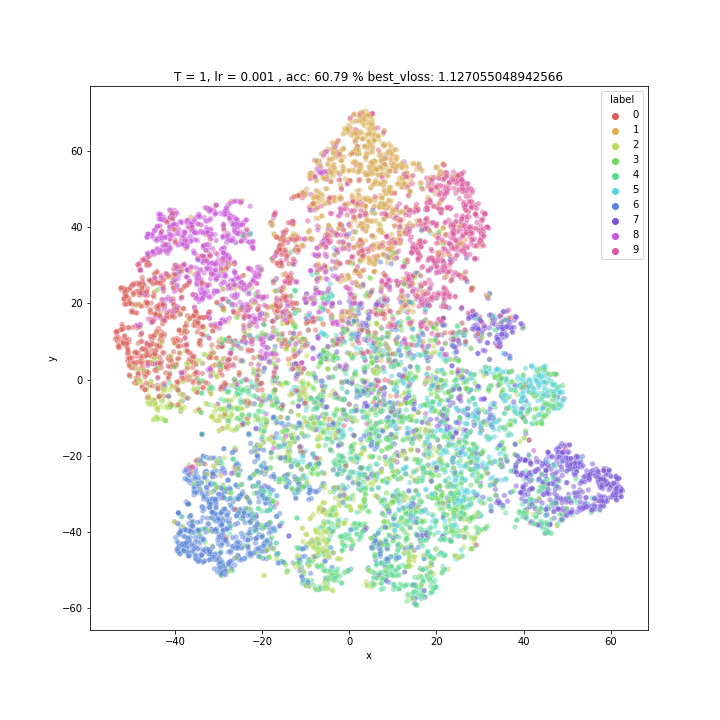

In [38]:
Image(filename=top3.loc[0,"plot_path"])


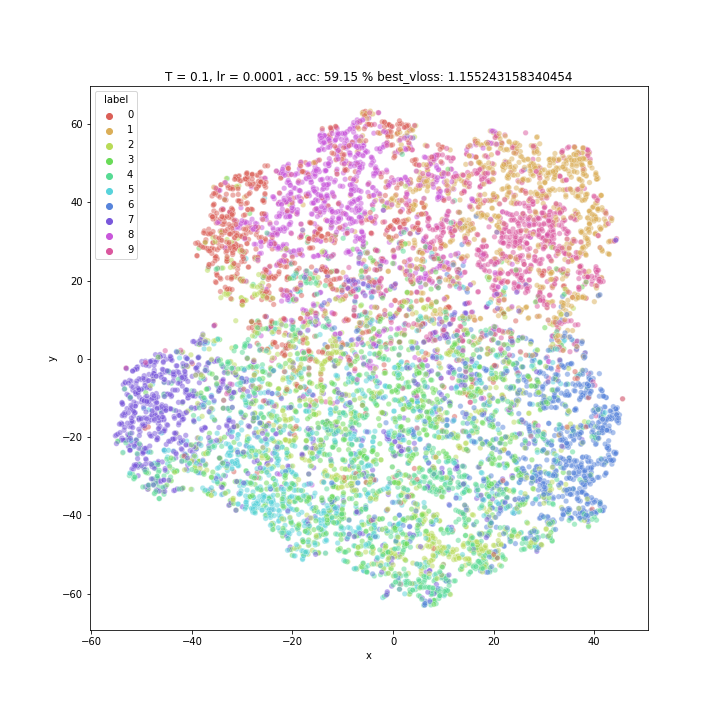

In [39]:
Image(filename=top3.loc[1,"plot_path"])


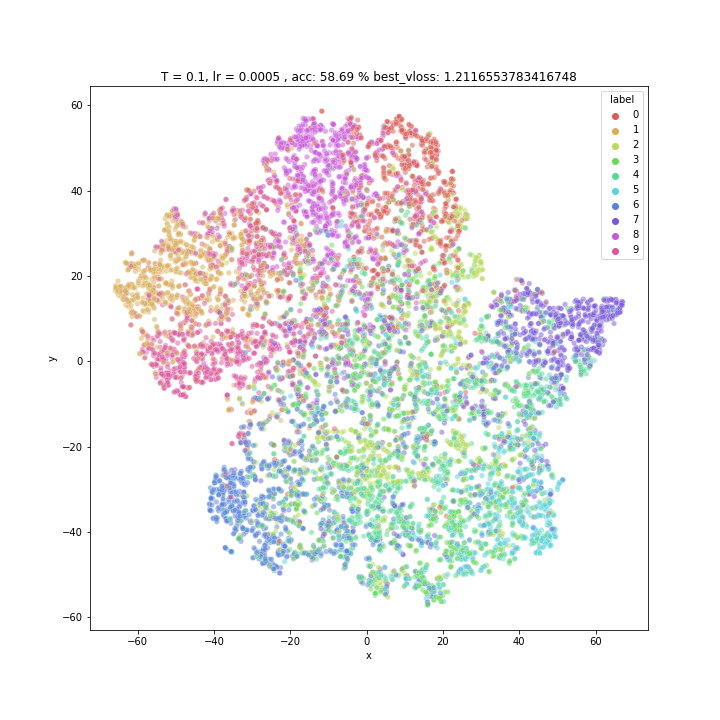

In [40]:
Image(filename=top3.loc[2,"plot_path"])


In [45]:
scores.sort_values('accuracy', ascending=False)

,T-value,learning_rate,accuracy,best_vloss,plot_path
6,1.00,0.0010,60.79,1.127055,plots/20220328_012453.png
2,0.10,0.0001,59.15,1.155243,plots/20220328_010206.png
5,0.10,0.0005,58.69,1.211655,plots/20220328_012049.png
22,30.00,0.0050,58.46,1.172163,plots/20220328_025014.png
4,1.00,0.0005,58.44,1.179207,plots/20220328_011442.png
14,10.00,0.0050,58.27,1.207848,plots/20220328_020434.png
9,5.00,0.0010,58.02,1.186387,plots/20220328_013849.png
1,0.05,0.0001,57.78,1.171214,plots/20220328_005617.png
17,20.00,0.0050,57.13,1.228196,plots/20220328_022044.png
23,30.00,0.0080,55.91,1.274640,plots/20220328_025418.png


# Summary
### The best result was obtained for vanilla softmax and a learning rate = 0.001.
### The second and third best results were obtained for a value of T equal to 0.1. To obtain the best results the learning rate had to be decreased.
### The fourth best result was obtained for a T value of 30 with a learning rate increased to 0.005
